# Import Libraries

In [592]:
import re
import unicodedata
import io

import joblib

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import svm

In [540]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [541]:
from fastai.imports import *
from fastai.tabular import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestClassifier
from IPython.display import display

from sklearn import metrics

# Define base directory and data path for source file

In [542]:
import os
import sys

base_dir = os.getcwd()
data_dir = os.path.join(base_dir, 'Data')

#Source File Path
in_data_pref = os.path.join(data_dir, 'Input')
src_file_name = 'Interview.csv'
src_data_path = os.path.join(in_data_pref , src_file_name)

In [543]:
#Read raw source file for inteview
df_raw = pd.read_csv(src_data_path)

In [544]:
df_raw.head()

Date of Interview Client name         Industry Location Position to be closed Nature of Skillset    Interview Type Name(Cand ID) Gender Candidate Current Location Candidate Job Location Interview Venue Candidate Native location Have you obtained the necessary permission to start at the required time Hope there will be no unscheduled meetings Can I Call you three hours before the interview and follow up on your attendance for the interview Can I have an alternative number/ desk number. I assure you that I will not trouble you too much Have you taken a printout of your updated resume. Have you read the JD and understood the same Are you clear with the venue details and the landmark. Has the call letter been shared Expected Attendance Observed Attendance Marital Status  Unnamed: 23  Unnamed: 24  Unnamed: 25  Unnamed: 26  Unnamed: 27
0        13.02.2015     Hospira  Pharmaceuticals  Chennai   Production- Sterile            Routine  Scheduled Walkin   Candidate 1   Male                    Chennai                  Hosur           Hosur                     Hosur                                                                      Yes                                        Yes                                                                                                Yes                                                                                              Yes                                                                                            Yes                                                    Yes                             Yes                 Yes                  No         Single          NaN          NaN          NaN          NaN          NaN
1        13.02.2015     Hospira  Pharmaceuticals  Chennai   Production- Sterile            Routine  Scheduled Walkin   Candidate 2   Male                    Chennai              Bangalore           Hosur                    Trichy                                                                      Yes                                        Yes                                                                                                Yes                                                                                              Yes                                                                                            Yes                                                    Yes                             Yes                 Yes                  No         Single          NaN          NaN          NaN          NaN          NaN
2        13.02.2015     Hospira  Pharmaceuticals  Chennai   Production- Sterile            Routine  Scheduled Walkin   Candidate 3   Male                    Chennai                Chennai           Hosur                   Chennai                                                                      NaN                                         Na                                                                                                NaN                                                                                              NaN                                                                                            NaN                                                    NaN                             NaN           Uncertain                  No         Single          NaN          NaN          NaN          NaN          NaN
3        13.02.2015     Hospira  Pharmaceuticals  Chennai   Production- Sterile            Routine  Scheduled Walkin   Candidate 4   Male                    Chennai                Chennai           Hosur                   Chennai                                                                      Yes                                        Yes                                                                                                 No                                                                                              Yes                                                                                     

In [545]:
#Removing empty columns
interview_df = df_raw.drop(['Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27'], axis = 1)

In [546]:
#Renaming the columns
interview_df.columns

Index(['Date of Interview', 'Client name', 'Industry', 'Location', 'Position to be closed', 'Nature of Skillset', 'Interview Type', 'Name(Cand ID)', 'Gender', 'Candidate Current Location', 'Candidate Job Location', 'Interview Venue', 'Candidate Native location', 'Have you obtained the necessary permission to start at the required time', 'Hope there will be no unscheduled meetings', 'Can I Call you three hours before the interview and follow up on your attendance for the interview', 'Can I have an alternative number/ desk number. I assure you that I will not trouble you too much', 'Have you taken a printout of your updated resume. Have you read the JD and understood the same', 'Are you clear with the venue details and the landmark.', 'Has the call letter been shared', 'Expected Attendance', 'Observed Attendance', 'Marital Status'], dtype='object')

In [547]:
interview_df.shape

(1234, 23)

In [548]:
# Renaming variables to strings that are a little easier to work with.
interview_df.columns = ['Date', 'Client', 'Industry', 'Location', 'Position', 'Skillset',
                        'Interview_Type', 'ID', 'Gender', 'Cand_Loc', 'Job_Loc', 'Venue',
                        'Native_Loc', 'Permission', 'Hope', 'Three_hour_call', 'Alt_phone',
                        'Resume_Printout', 'Clarify_Venue', 'Shared_Letter', 'Expected', 
                        'Attended', 'Martial_Status']

In [549]:
#Check for unique values
for c in interview_df.columns:
    print(c)
    print(interview_df[c].unique())

Date
['13.02.2015' '19.06.2015' '23.06.2015' '29.06.2015' ... '30.01.16' '30-1-2016' '06.05.2016' nan]
Client
['Hospira' 'Aon Hewitt' 'UST' 'Standard Chartered Bank' 'ANZ' 'Pfizer' 'Standard Chartered Bank Chennai'
 'Aon hewitt Gurgaon' 'Astrazeneca' 'Flextronics' 'Prodapt' 'Williams Lea' 'Barclays' 'Hewitt' 'Woori Bank'
 '\ufeff\ufeff']
Industry
['Pharmaceuticals' 'IT Services' 'BFSI' 'IT Products and Services' 'Electronics' 'Telecom' 'IT' nan]
Location
['Chennai' 'Gurgaon' 'Bangalore' 'Hyderabad' 'Gurgaonr' 'Delhi' 'chennai' '- Cochin- ' 'Noida' 'CHENNAI' 'chennai ' nan]
Position
['Production- Sterile' 'Selenium testing' 'Dot Net' 'AML' 'Trade Finance' 'Routine' 'Niche' nan]
Skillset
['Routine' 'Oracle' 'Accounting Operations' 'Banking Operations' ... 'Java, XML, Struts, hibernate' 'JAVA/J2EE' 'Java '
 nan]
Interview_Type
['Scheduled Walkin' 'Scheduled ' 'Walkin' 'Scheduled Walk In' 'Sceduled walkin' 'Walkin ' nan]
ID
['Candidate 1' 'Candidate 2' 'Candidate 3' 'Candidate 4' ... 'Cand

In [550]:
print(interview_df['Date'].unique())

['13.02.2015' '19.06.2015' '23.06.2015' '29.06.2015' ... '30.01.16' '30-1-2016' '06.05.2016' nan]


In [551]:
def clean_date(date):
    date = date.str.strip()
    date = date.str.split("&").str[0]
    date = date.str.replace('–', '/')
    date = date.str.replace('.', '/')
    date = date.str.replace('Apr', '04')
    date = date.str.replace('-', '/')
    date = date.str.replace(' ', '/')
    date = date.str.replace('//+', '/')
    return date

In [552]:
interview_df['Date'] = clean_date(interview_df['Date'])

In [553]:
interview_df.drop(interview_df.index[[1233]], inplace = True)

In [554]:
# Create my new date variables
interview_df['year'] = interview_df['Date'].str.split("/").str[2]
interview_df['day'] = interview_df['Date'].str.split("/").str[0]
interview_df['month'] = interview_df['Date'].str.split("/").str[1]

# This will find the short years and replace with long years
interview_df['year'].replace(['16', '15'], ['2016', '2015'], inplace = True)

# Finally I create the new Date column
interview_df['date'] = pd.to_datetime(pd.DataFrame({'year': interview_df['year'],
                                            'month': interview_df['month'],
                                            'day': interview_df['day']}), format = '%Y-%m-%d')
interview_df.head()

Date   Client         Industry Location             Position Skillset    Interview_Type           ID Gender Cand_Loc    Job_Loc  Venue Native_Loc Permission Hope Three_hour_call Alt_phone Resume_Printout Clarify_Venue Shared_Letter   Expected Attended Martial_Status  year day month       date
0  13/02/2015  Hospira  Pharmaceuticals  Chennai  Production- Sterile  Routine  Scheduled Walkin  Candidate 1   Male  Chennai      Hosur  Hosur      Hosur        Yes  Yes             Yes       Yes             Yes           Yes           Yes        Yes       No         Single  2015  13    02 2015-02-13
1  13/02/2015  Hospira  Pharmaceuticals  Chennai  Production- Sterile  Routine  Scheduled Walkin  Candidate 2   Male  Chennai  Bangalore  Hosur     Trichy        Yes  Yes             Yes       Yes             Yes           Yes           Yes        Yes       No         Single  2015  13    02 2015-02-13
2  13/02/2015  Hospira  Pharmaceuticals  Chennai  Production- Sterile  Routine  Scheduled Walkin  Candidate 3   Male  Chennai    Chennai  Hosur    Chennai        NaN   Na             NaN       NaN             NaN           NaN           NaN  Uncertain       No         Single  2015  13    02 2015-02-13
3  13/02/2015  Hospira  Pharmaceuticals  Chennai  Production- Sterile  Routine  Scheduled Walkin  Candidate 4   Male  Chennai    Chennai  Hosur    Chennai        Yes  Yes              No       Yes              No           Yes           Yes  Uncertain       No         Single  2015  13    02 2015-02-13
4  13/02/2015  Hospira  Pharmaceuticals  Chennai  Production- Sterile  Routine  Scheduled Walkin  Candidate 5   Male  Chennai  Bangalore  Hosur    Chennai        Yes  Yes             Yes        No             Yes           Yes           Yes  Uncertain       No        Married  2015  13    02 2015-02-13

In [555]:
interview_df.drop(['Date', 'year', 'month', 'day'], axis = 1, inplace = True)

In [556]:
interview_df = pd.concat([interview_df[c].astype(str).str.lower() for c in interview_df.columns], axis = 1)
interview_df = pd.concat([interview_df[c].astype(str).str.strip() for c in interview_df.columns], axis = 1)

In [557]:
interview_df['Client'].value_counts()

standard chartered bank            904
hospira                             75
pfizer                              75
aon hewitt                          28
flextronics                         23
anz                                 22
hewitt                              20
ust                                 18
prodapt                             17
standard chartered bank chennai     17
astrazeneca                         15
williams lea                        11
barclays                             5
aon hewitt gurgaon                   2
woori bank                           1
Name: Client, dtype: int64

In [558]:
interview_df['Client'].replace(['standard chartered bank chennai', 'aon hewitt gurgaon', 'hewitt'], 
                              ['standard chartered bank', 'aon hewitt', 'aon hewitt'], inplace = True)

In [559]:
interview_df['Industry'].replace(['it products and services', 'it services'], 
                              ['it', 'it'], inplace = True)

interview_df['Location'].replace(['- cochin-'], 
                              ['cochin'], inplace = True)

# I'm really not sure about this Interview_Type variable. I'd ask if given the chance. For now I'm just going
# to use 'scheduled walkin', 'walkin' and 'scheduled'
interview_df['Interview_Type'].replace(['scheduled walk in', 'sceduled walkin'],
                                       ['scheduled walkin', 'scheduled walkin'], inplace = True)
# I wonder why  cochin is always messed up?
interview_df['Cand_Loc'].replace(['- cochin-'], 
                              ['cochin'], inplace = True)
interview_df['Job_Loc'].replace(['- cochin-'], 
                              ['cochin'], inplace = True)
interview_df['Venue'].replace(['- cochin-'], 
                              ['cochin'], inplace = True)
# I'm assuming all these native locations are actual places. I didn't check them all
interview_df['Native_Loc'].replace(['- cochin-'], 
                              ['cochin'], inplace = True)
# I don't know if nan's and 'not yet' are actually different, but I'm treating them like they are
interview_df['Permission'].replace(['na', 'not yet', 'yet to confirm'], 
                              ['nan', 'tbd', 'tbd'], inplace = True)
interview_df['Hope'].replace(['na', 'not sure', 'cant say'], 
                              ['nan', 'unsure', 'unsure'], inplace = True)
interview_df['Three_hour_call'].replace(['na', 'no dont'], 
                              ['nan', 'no'], inplace = True)
interview_df['Hope'].replace(['na', 'not sure', 'cant say'], 
                              ['nan', 'unsure', 'unsure'], inplace = True)
interview_df['Alt_phone'].replace(['na', 'no i have only thi number'], 
                              ['nan', 'no'], inplace = True)
interview_df['Resume_Printout'].replace(['na', 'not yet', 'no- will take it soon'], 
                              ['nan', 'ny', 'ny'], inplace = True)
interview_df['Clarify_Venue'].replace(['na', 'no- i need to check'], 
                              ['nan', 'no'], inplace = True)
interview_df['Shared_Letter'].replace(['na', 'not sure', 'need to check', 'not yet', 'yet to check',
                                       'havent checked'],
                                      ['nan', 'unsure', 'unsure', 'unsure', 'unsure', 'unsure'], inplace = True)
interview_df['Expected'].replace(['na', '11:00 am', '10.30 am'], 
                              ['nan', 'nan', 'nan'], inplace = True)
interview_df['Attended'].replace(['yes', 'no'],
                                 [1, 0], inplace = True)

In [530]:
modeling_df = interview_df.drop(['Skillset'], axis = 1)

In [403]:
add_datepart(modeling_df, 'date')

Client         Industry   Location             Position    Interview_Type              ID  Gender   Cand_Loc        Job_Loc      Venue     Native_Loc Permission    Hope Three_hour_call Alt_phone Resume_Printout Clarify_Venue Shared_Letter   Expected  Attended Martial_Status  Year  Month  Week  Day  Dayofweek  Dayofyear  Is_month_end  Is_month_start  Is_quarter_end  Is_quarter_start  Is_year_end  Is_year_start     Elapsed
0                     hospira  pharmaceuticals    chennai  production- sterile  scheduled walkin     candidate 1    male    chennai          hosur      hosur          hosur        yes     yes             yes       yes             yes           yes           yes        yes         0         single  2015      2     7   13          4         44         False           False           False             False        False          False  1423785600
1                     hospira  pharmaceuticals    chennai  production- sterile  scheduled walkin     candidate 2    male    chennai      bangalore      hosur         trichy        yes     yes             yes       yes             yes           yes           yes        yes         0         single  2015      2     7   13          4         44         False           False           False             False        False          False  1423785600
2                     hospira  pharmaceuticals    chennai  production- sterile  scheduled walkin     candidate 3    male    chennai        chennai      hosur        chennai        nan     nan             nan       nan             nan           nan           nan  uncertain         0         single  2015      2     7   13          4         44         False           False           False             False        False          False  1423785600
3                     hospira  pharmaceuticals    chennai  production- sterile  scheduled walkin     candidate 4    male    chennai        chennai      hosur        chennai        yes     yes              no       yes              no           yes           yes  uncertain         0         single  2015      2     7   13          4         44         False           False           False             False        False          False  1423785600
4                     hospira  pharmaceuticals    chennai  production- sterile  scheduled walkin     candidate 5    male    chennai      bangalore      hosur        chennai        yes     yes             yes        no             yes           yes           yes  uncertain         0        married  2015      2     7   13          4         44         False           False           False             False        False          False  1423785600
5                  aon hewitt               it    gurgaon     selenium testing  scheduled walkin     candidate 6    male    gurgaon        gurgaon    gurgaon        gurgaon        yes     yes             yes       yes             yes           yes           yes        yes         1         single  2015      2     7   13          4         44         False           False           False             False        False          False  1423785600
6                  aon hewitt               it    gurgaon     selenium testing  scheduled walkin     candidate 7    male    gurgaon        gurgaon    gurgaon        gurgaon        yes     yes             yes       yes             yes           yes           yes        yes         1         single  2015      2     7   13          4         44         False           False           False             False        False          False  1423785600
7                  aon hewitt               it    gurgaon     selenium testing  scheduled walkin     candidate 8  female    gurgaon        gurgaon    gurgaon          noida        yes     yes             yes       yes             yes           yes           yes        yes         1         single  2015      2     7   13          4         44         False           False           False             False        False          False  14

In [560]:
interview_df.columns

Index(['Client', 'Industry', 'Location', 'Position', 'Skillset', 'Interview_Type', 'ID', 'Gender', 'Cand_Loc', 'Job_Loc', 'Venue', 'Native_Loc', 'Permission', 'Hope', 'Three_hour_call', 'Alt_phone', 'Resume_Printout', 'Clarify_Venue', 'Shared_Letter', 'Expected', 'Attended', 'Martial_Status', 'date'], dtype='object')

# Creating Features

In [561]:
interview_df

Client         Industry   Location             Position                                Skillset    Interview_Type              ID  Gender   Cand_Loc        Job_Loc      Venue     Native_Loc Permission    Hope Three_hour_call Alt_phone Resume_Printout Clarify_Venue Shared_Letter   Expected  Attended Martial_Status        date
0                     hospira  pharmaceuticals    chennai  production- sterile                                 routine  scheduled walkin     candidate 1    male    chennai          hosur      hosur          hosur        yes     yes             yes       yes             yes           yes           yes        yes         0         single  2015-02-13
1                     hospira  pharmaceuticals    chennai  production- sterile                                 routine  scheduled walkin     candidate 2    male    chennai      bangalore      hosur         trichy        yes     yes             yes       yes             yes           yes           yes        yes         0         single  2015-02-13
2                     hospira  pharmaceuticals    chennai  production- sterile                                 routine  scheduled walkin     candidate 3    male    chennai        chennai      hosur        chennai        nan     nan             nan       nan             nan           nan           nan  uncertain         0         single  2015-02-13
3                     hospira  pharmaceuticals    chennai  production- sterile                                 routine  scheduled walkin     candidate 4    male    chennai        chennai      hosur        chennai        yes     yes              no       yes              no           yes           yes  uncertain         0         single  2015-02-13
4                     hospira  pharmaceuticals    chennai  production- sterile                                 routine  scheduled walkin     candidate 5    male    chennai      bangalore      hosur        chennai        yes     yes             yes        no             yes           yes           yes  uncertain         0        married  2015-02-13
5                  aon hewitt               it    gurgaon     selenium testing                                 routine  scheduled walkin     candidate 6    male    gurgaon        gurgaon    gurgaon        gurgaon        yes     yes             yes       yes             yes           yes           yes        yes         1         single  2015-02-13
6                  aon hewitt               it    gurgaon     selenium testing                                 routine  scheduled walkin     candidate 7    male    gurgaon        gurgaon    gurgaon        gurgaon        yes     yes             yes       yes             yes           yes           yes        yes         1         single  2015-02-13
7                  aon hewitt               it    gurgaon     selenium testing                                 routine  scheduled walkin     candidate 8  female    gurgaon        gurgaon    gurgaon          noida        yes     yes             yes       yes             yes           yes           yes        yes         1         single  2015-02-13
8                  aon hewitt               it    gurgaon     selenium testing                                 routine  scheduled walkin     candidate 9    male    gurgaon        gurgaon    gurgaon     delhi /ncr        yes     yes             yes       yes             yes           yes           yes        yes         1         single  2015-02-13
9                  aon hewitt               it    gurgaon     selenium testing                                 routine  scheduled walkin    candidate 10  female    gurgaon        gurgaon    gurgaon     delhi /ncr        yes     yes             yes       yes             yes           yes           yes        yes         0         single  2015-02-13
10                        ust               it  bangalore              dot net                                 routine  scheduled walkin    candidate 11    male  bangalore  

In [562]:
interview_df['Permission'].replace({'yes':1, 'no':0}, inplace=True)
interview_df['Hope'].replace({'yes':1, 'no':0}, inplace=True)
interview_df['Three_hour_call'].replace({'yes':1, 'no':0}, inplace=True)
interview_df['Alt_phone'].replace({'yes':1, 'no':0}, inplace=True)
interview_df['Resume_Printout'].replace({'yes':1, 'no':0}, inplace=True)
interview_df['Clarify_Venue'].replace({'yes':1, 'no':0}, inplace=True)
interview_df['Shared_Letter'].replace({'yes':1, 'no':0, 'unsure':np.nan}, inplace=True)
interview_df['Expected'].replace({'yes':1, 'no':0, 'uncertain':np.nan}, inplace=True)

In [677]:
categorical_features = ['Client','Industry','Location','Position','Interview_Type','Cand_Loc','Job_Loc','Venue','Native_Loc','Gender','Martial_Status']
boolean_features = ['Permission','Hope','Three_hour_call','Alt_phone','Resume_Printout','Clarify_Venue','Shared_Letter','Expected','Attended']

for feature in boolean_features:
    interview_df[feature] = interview_df[feature].astype("bool")

for feature in categorical_features:
    interview_df[feature] = interview_df[feature].astype("category")

In [656]:
interview_df

Client         Industry   Location             Position                                Skillset    Interview_Type              ID  Gender   Cand_Loc        Job_Loc      Venue     Native_Loc  Permission   Hope  Three_hour_call  Alt_phone  Resume_Printout  Clarify_Venue  Shared_Letter Expected  Attended Martial_Status        date
0                     hospira  pharmaceuticals    chennai  production- sterile                                 routine  scheduled walkin     candidate 1    male    chennai          hosur      hosur          hosur        True   True             True       True             True           True           True        1     False         single  2015-02-13
1                     hospira  pharmaceuticals    chennai  production- sterile                                 routine  scheduled walkin     candidate 2    male    chennai      bangalore      hosur         trichy        True   True             True       True             True           True           True        1     False         single  2015-02-13
2                     hospira  pharmaceuticals    chennai  production- sterile                                 routine  scheduled walkin     candidate 3    male    chennai        chennai      hosur        chennai        True   True             True       True             True           True           True      NaN     False         single  2015-02-13
3                     hospira  pharmaceuticals    chennai  production- sterile                                 routine  scheduled walkin     candidate 4    male    chennai        chennai      hosur        chennai        True   True            False       True            False           True           True      NaN     False         single  2015-02-13
4                     hospira  pharmaceuticals    chennai  production- sterile                                 routine  scheduled walkin     candidate 5    male    chennai      bangalore      hosur        chennai        True   True             True      False             True           True           True      NaN     False        married  2015-02-13
5                  aon hewitt               it    gurgaon     selenium testing                                 routine  scheduled walkin     candidate 6    male    gurgaon        gurgaon    gurgaon        gurgaon        True   True             True       True             True           True           True        1      True         single  2015-02-13
6                  aon hewitt               it    gurgaon     selenium testing                                 routine  scheduled walkin     candidate 7    male    gurgaon        gurgaon    gurgaon        gurgaon        True   True             True       True             True           True           True        1      True         single  2015-02-13
7                  aon hewitt               it    gurgaon     selenium testing                                 routine  scheduled walkin     candidate 8  female    gurgaon        gurgaon    gurgaon          noida        True   True             True       True             True           True           True        1      True         single  2015-02-13
8                  aon hewitt               it    gurgaon     selenium testing                                 routine  scheduled walkin     candidate 9    male    gurgaon        gurgaon    gurgaon     delhi /ncr        True   True             True       True             True           True           True        1      True         single  2015-02-13
9                  aon hewitt               it    gurgaon     selenium testing                                 routine  scheduled walkin    candidate 10  female    gurgaon        gurgaon    gurgaon     delhi /ncr        True   True             True       True             True           True           True        1     False         single  2015-02-13
10                        ust               it  bangalore              dot net                                 routine  scheduled walkin    

# Feature selection by Pearson correlation with output

In [678]:
one_hot_features = pd.get_dummies(interview_df.drop(["ID","Client", "Industry","Location","Position","Native_Loc","Venue","Permission","Job_Loc","Cand_Loc","Hope","date","Skillset","Gender","Martial_Status","Interview_Type","Attended"], axis=1)).columns

In [679]:
one_hot_features

Index(['Three_hour_call', 'Alt_phone', 'Resume_Printout', 'Clarify_Venue', 'Shared_Letter', 'Expected'], dtype='object')

In [680]:
X = pd.get_dummies(interview_df.drop(["ID","Client", "Industry","Location","Position","Native_Loc","Venue","Permission","Job_Loc","Cand_Loc","Hope","date","Skillset","Gender","Martial_Status","Interview_Type","Attended"], axis=1)).values
y = interview_df['Attended'].values

X = X.astype("float64")
y = y.astype("float64")

X = interview_df[one_hot_features]
y = interview_df["Attended"]

In [681]:
one_hot_features

Index(['Three_hour_call', 'Alt_phone', 'Resume_Printout', 'Clarify_Venue', 'Shared_Letter', 'Expected'], dtype='object')

In [682]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.3, random_state=7, shuffle = True)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=.5, random_state=7, shuffle = True)

In [683]:
rf = RandomForestClassifier()
model_rf = rf.fit(X_train,y_train)
y_pred_rf = model_rf.predict(X_test)

C:\Users\sumit.ghose.roy\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [684]:
model_rf = rf.fit(X_train.as_matrix(), y_train.as_matrix())

C:\Users\sumit.ghose.roy\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [685]:
model_rf.predict_proba(X_val.as_matrix()[0].reshape(1, 6))

C:\Users\sumit.ghose.roy\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


array([[0.310145, 0.689855]])

In [688]:
inp = np.array([1, 0, 1, 1, 1, 1])

In [689]:
model_rf.predict_proba(inp.reshape(1, 6))

array([[0.291039, 0.708961]])

In [579]:
train_df = pd.DataFrame(data=X_train, columns=one_hot_features)
train_df["Attended"] = y_train
train_df

Three_hour_call  Alt_phone  Resume_Printout  Clarify_Venue  Shared_Letter  Interview_Type_scheduled  Interview_Type_scheduled walkin  Interview_Type_walkin  Gender_female  Gender_male  Expected_0  Expected_1  Expected_nan  Martial_Status_married  Martial_Status_single  Attended
0                1.0        1.0              1.0            1.0            1.0                       0.0                              1.0                    0.0            0.0          1.0         0.0         1.0           0.0                     0.0                    1.0       0.0
1                1.0        1.0              1.0            1.0            1.0                       0.0                              1.0                    0.0            0.0          1.0         0.0         1.0           0.0                     0.0                    1.0       0.0
2                1.0        1.0              1.0            1.0            1.0                       0.0                              1.0                    0.0            0.0          1.0         0.0         1.0           0.0                     1.0                    0.0       0.0
3                1.0        1.0              1.0            1.0            1.0                       1.0                              0.0                    0.0            0.0          1.0         0.0         0.0           1.0                     0.0                    1.0       0.0
4                1.0        1.0              1.0            1.0            1.0                       0.0                              1.0                    0.0            0.0          1.0         0.0         1.0           0.0                     0.0                    1.0       0.0
5                1.0        1.0              1.0            1.0            1.0                       0.0                              1.0                    0.0            0.0          1.0         0.0         1.0           0.0                     0.0                    1.0       0.0
6                1.0        1.0              1.0            1.0            1.0                       0.0                              1.0                    0.0            1.0          0.0         0.0         1.0           0.0                     1.0                    0.0       1.0
7                1.0        1.0              1.0            1.0            1.0                       0.0                              1.0                    0.0            0.0          1.0         0.0         0.0           0.0                     1.0                    0.0       0.0
8                1.0        1.0              1.0            1.0            1.0                       0.0                              1.0                    0.0            0.0          1.0         0.0         1.0           0.0                     0.0                    1.0       1.0
9                1.0        1.0              1.0            1.0            1.0                       1.0                              0.0                    0.0            1.0          0.0         0.0         0.0           0.0                     0.0                    1.0       0.0
10               1.0        1.0              1.0            1.0            1.0                       0.0                              1.0                    0.0            1.0          0.0         0.0         1.0           0.0                     0.0                    1.0       1.0
11               1.0        1.0              1.0            0.0            1.0                       1.0                              0.0                    0.0            0.0          1.0         0.0         0.0           1.0                     1.0                    0.0       1.0
12               1.0        1.0              1.0            1.0            1.0                       1.0                              0.0                    0.0            0.0          1.0         0.0         1.0           0.0                     0.0                    1.0       1.0
13               1.0        1

In [700]:
corr_tresh = 2 / np.sqrt(X_train.shape[0])
print("Correlation treshold: {:.4f}".format(corr_tresh))

Correlation treshold: 0.0681


In [581]:
r = pd.DataFrame(train_df.corr())
output_r = pd.DataFrame(r.loc[:, "Attended"].abs())
output_r["correlated"] = output_r > corr_tresh
output_r
#output_r[output_r["correlated"] == True]

Attended  correlated
Three_hour_call                  0.038287       False
Alt_phone                        0.090628        True
Resume_Printout                  0.119639        True
Clarify_Venue                    0.106268        True
Shared_Letter                    0.076785        True
Interview_Type_scheduled         0.045718       False
Interview_Type_scheduled walkin  0.007412       False
Interview_Type_walkin            0.046228       False
Gender_female                    0.016691       False
Gender_male                      0.016691       False
Expected_0                       0.358744        True
Expected_1                       0.347324        True
Expected_nan                     0.018781       False
Martial_Status_married           0.016662       False
Martial_Status_single            0.016662       False
Attended                         1.000000        True

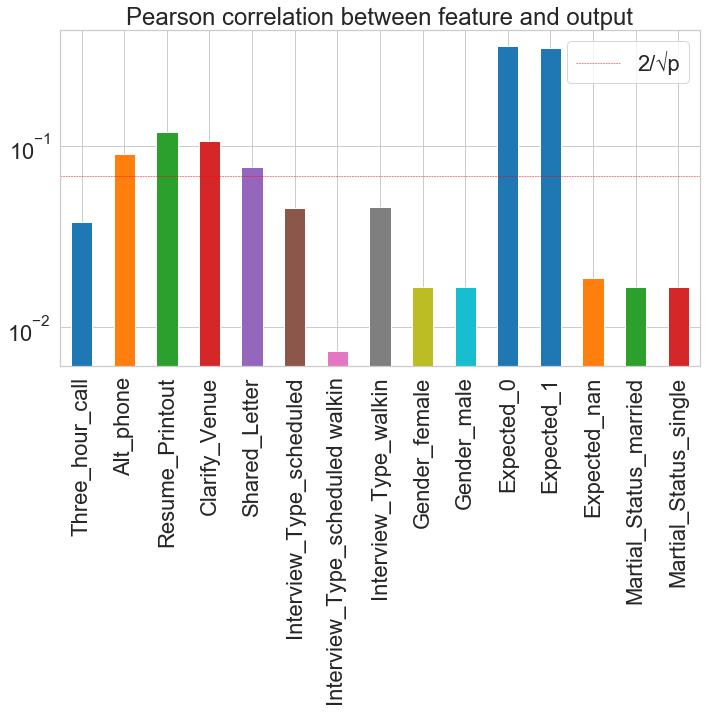

In [584]:
plt.figure(figsize=(10, 10))
plt.title("Pearson correlation between feature and output")
output_r.loc[output_r.index != "Attended", "Attended"].plot(kind="bar", label="")
tresh_line = plt.axhline(corr_tresh, linewidth=0.5, linestyle="--", color='r', label="2/√p")
plt.yscale("log")
plt.legend()
plt.tight_layout()
plt.show()

# Removing interview_type,  gender and Marital_Status as they are not correlated enough with the output.

In [648]:
one_hot_features = pd.get_dummies(interview_df.drop(["ID","Client", "Industry","Location","Position","Native_Loc","Venue","Permission","Job_Loc","Cand_Loc","Hope","date","Skillset","Interview_Type","Gender","Martial_Status","Attended"], axis=1)).columns
X = pd.get_dummies(interview_df.drop(["ID","Client", "Industry","Location","Position","Native_Loc","Venue","Permission","Job_Loc","Cand_Loc","Hope","date","Skillset","Interview_Type","Gender","Martial_Status","Attended"], axis=1)).values
y = interview_df.Attended.values

X = X.astype("float64")
y = y.astype("float64")

In [649]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.3, random_state=7, shuffle = True)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=.5, random_state=7, shuffle = True)

In [650]:
one_hot_features

Index(['Three_hour_call', 'Alt_phone', 'Resume_Printout', 'Clarify_Venue', 'Shared_Letter', 'Expected_0', 'Expected_1', 'Expected_nan'], dtype='object')

# Modeling

In [652]:
log = LogisticRegression()
model_log=log.fit(X_train,y_train)
y_pred_log=model_log.predict(X_test)

C:\Users\sumit.ghose.roy\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [590]:
from sklearn.model_selection import cross_val_score
log_cv_score = cross_val_score(model_log, X, y, cv=10, scoring='roc_auc')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Logistic Regression : ", log_cv_score.mean())

C:\Users\sumit.ghose.roy\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sumit.ghose.roy\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sumit.ghose.roy\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sumit.ghose.roy\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\sumit.ghose.roy\AppData\Local\C

=== Mean AUC Score ===
Mean AUC Score - Logistic Regression :  0.6758188178441344


Confusion Matrix :
 [[0.428571 0.571429]
 [0.2      0.8     ]]


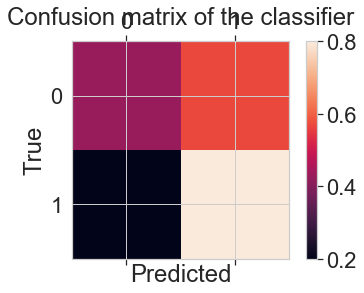

Classioficaton Report :
               precision    recall  f1-score   support

     No-Show       0.57      0.43      0.49        70
        Show       0.70      0.80      0.74       115

   micro avg       0.66      0.66      0.66       185
   macro avg       0.63      0.61      0.62       185
weighted avg       0.65      0.66      0.65       185

Precision score: 0.696969696969697
Recall score: 0.8
f1_score : 0.7449392712550608
fbeta_score_0.5 : 0.7153965785381027
fbeta_score_1 : 0.7449392712550608
fbeta_score_2 : 0.7770270270270272
precision_recall_fscore_support : (array([0.566038, 0.69697 ]), array([0.428571, 0.8     ]), array([0.531915, 0.715397]), array([ 70, 115], dtype=int64))
Accuracy Score: 0.6594594594594595
Loss: 0.34054054054054056


In [594]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_log.round())
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Confusion Matrix :\n', cm)


fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
#ax.set_xticklabels([''] + labels)
#ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, hamming_loss
target_names = ['No-Show', 'Show']
print('Classioficaton Report :\n', classification_report(y_test, y_pred_log.round(), target_names=target_names))

from sklearn import metrics
print('Precision score:', metrics.precision_score(y_test, y_pred_log.round()))
print('Recall score:', metrics.recall_score(y_test, y_pred_log.round()))
print('f1_score :', metrics.f1_score(y_test, y_pred_log.round()))  
print('fbeta_score_0.5 :', metrics.fbeta_score(y_test, y_pred_log.round(), beta=0.5))
print('fbeta_score_1 :', metrics.fbeta_score(y_test, y_pred_log.round(), beta=1)) 
print('fbeta_score_2 :', metrics.fbeta_score(y_test, y_pred_log.round(), beta=2)) 
print('precision_recall_fscore_support :', metrics.precision_recall_fscore_support(y_test, y_pred_log.round(), beta=0.5))
print('Accuracy Score:', accuracy_score(y_test,  y_pred_log.round(), normalize=True, sample_weight=None))
print('Loss:', hamming_loss(y_test, y_pred_log.round()))

In [595]:
rf = RandomForestClassifier(max_depth=3, n_estimators=10)
model_rf = rf.fit(X_train,y_train)
y_pred_rf = model_rf.predict(X_test)

In [596]:
from sklearn.model_selection import cross_val_score
rf_cv_score = cross_val_score(model_rf, X, y, cv=10, scoring='roc_auc')
print("=== Mean AUC Score ===")
print("Mean AUC Score - Random Forest Classifier : ", rf_cv_score.mean())

=== Mean AUC Score ===
Mean AUC Score - Random Forest Classifier :  0.6778298892855855


Confusion Matrix :
 [[0.242857 0.757143]
 [0.008696 0.991304]]


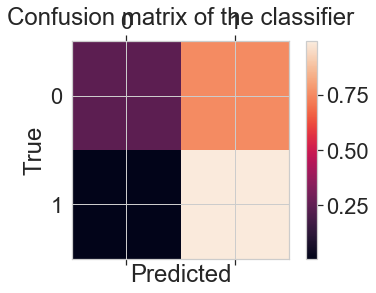

Classioficaton Report :
               precision    recall  f1-score   support

     No-Show       0.94      0.24      0.39        70
        Show       0.68      0.99      0.81       115

   micro avg       0.71      0.71      0.71       185
   macro avg       0.81      0.62      0.60       185
weighted avg       0.78      0.71      0.65       185

Precision score: 0.6826347305389222
Recall score: 0.991304347826087
f1_score : 0.8085106382978724
fbeta_score_0.5 : 0.7279693486590039
fbeta_score_1 : 0.8085106382978724
fbeta_score_2 : 0.9090909090909091
precision_recall_fscore_support : (array([0.944444, 0.682635]), array([0.242857, 0.991304]), array([0.598592, 0.727969]), array([ 70, 115], dtype=int64))
Accuracy Score: 0.7081081081081081
Loss: 0.2918918918918919


In [597]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_rf.round())
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Confusion Matrix :\n', cm)


fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
#ax.set_xticklabels([''] + labels)
#ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, hamming_loss
target_names = ['No-Show', 'Show']
print('Classioficaton Report :\n', classification_report(y_test, y_pred_rf.round(), target_names=target_names))

from sklearn import metrics
print('Precision score:', metrics.precision_score(y_test, y_pred_rf.round()))
print('Recall score:', metrics.recall_score(y_test, y_pred_rf.round()))
print('f1_score :', metrics.f1_score(y_test, y_pred_rf.round()))  
print('fbeta_score_0.5 :', metrics.fbeta_score(y_test, y_pred_rf.round(), beta=0.5))
print('fbeta_score_1 :', metrics.fbeta_score(y_test, y_pred_rf.round(), beta=1)) 
print('fbeta_score_2 :', metrics.fbeta_score(y_test, y_pred_rf.round(), beta=2)) 
print('precision_recall_fscore_support :', metrics.precision_recall_fscore_support(y_test, y_pred_rf.round(), beta=0.5))
print('Accuracy Score:', accuracy_score(y_test,  y_pred_rf.round(), normalize=True, sample_weight=None))
print('Loss:', hamming_loss(y_test, y_pred_rf.round()))

In [598]:
xgb = XGBClassifier(n_estimators=400, scale_pos_weight=((y_train == 0).sum() / y_train.sum()))
model_xgb = xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)

Confusion Matrix :
 [[0.471429 0.528571]
 [0.208696 0.791304]]


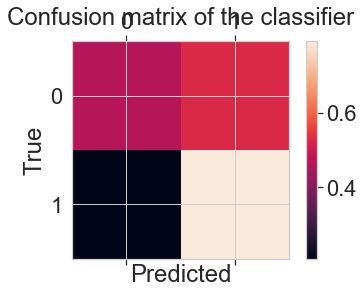

Classioficaton Report :
               precision    recall  f1-score   support

     No-Show       0.58      0.47      0.52        70
        Show       0.71      0.79      0.75       115

   micro avg       0.67      0.67      0.67       185
   macro avg       0.64      0.63      0.63       185
weighted avg       0.66      0.67      0.66       185

Precision score: 0.7109375
Recall score: 0.7913043478260869
f1_score : 0.7489711934156379
fbeta_score_0.5 : 0.7256778309409888
fbeta_score_1 : 0.7489711934156379
fbeta_score_2 : 0.7738095238095238
precision_recall_fscore_support : (array([0.578947, 0.710938]), array([0.471429, 0.791304]), array([0.553691, 0.725678]), array([ 70, 115], dtype=int64))
Accuracy Score: 0.6702702702702703
Loss: 0.32972972972972975


In [599]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_xgb.round())
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Confusion Matrix :\n', cm)


fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
#ax.set_xticklabels([''] + labels)
#ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, hamming_loss
target_names = ['No-Show', 'Show']
print('Classioficaton Report :\n', classification_report(y_test, y_pred_xgb.round(), target_names=target_names))

from sklearn import metrics
print('Precision score:', metrics.precision_score(y_test, y_pred_xgb.round()))
print('Recall score:', metrics.recall_score(y_test, y_pred_xgb.round()))
print('f1_score :', metrics.f1_score(y_test, y_pred_xgb.round()))  
print('fbeta_score_0.5 :', metrics.fbeta_score(y_test, y_pred_xgb.round(), beta=0.5))
print('fbeta_score_1 :', metrics.fbeta_score(y_test, y_pred_xgb.round(), beta=1)) 
print('fbeta_score_2 :', metrics.fbeta_score(y_test, y_pred_xgb.round(), beta=2)) 
print('precision_recall_fscore_support :', metrics.precision_recall_fscore_support(y_test, y_pred_xgb.round(), beta=0.5))
print('Accuracy Score:', accuracy_score(y_test,  y_pred_xgb.round(), normalize=True, sample_weight=None))
print('Loss:', hamming_loss(y_test, y_pred_xgb.round()))

In [603]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
xgb = XGBClassifier()
xgb.fit(train_dataset, y_train)

y_pred_xgb = xgb.predict_proba(test_dataset)[:, 1]
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_xgb)
auc_xgb = auc(fpr_xgb, tpr_xgb)

In [600]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
nsamples, nx = X_train.shape
nsamplesx, nxx = X_test.shape
train_dataset = X_train.reshape((nsamples,nx))
test_dataset = X_test.reshape((nsamplesx,nxx))

rf = RandomForestClassifier(max_depth=3, n_estimators=10)
rf.fit(train_dataset, y_train)

y_pred_rf = rf.predict_proba(test_dataset)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)

In [601]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
log = LogisticRegression()
log.fit(train_dataset, y_train)
#y_pred_log = model_log.predict_proba(test_dataset)[:, 1]
y_pred_log = log.predict_proba(test_dataset)[:, 1]

fpr_log, tpr_log, thresholds_log = roc_curve(y_test, y_pred_log)
auc_log = auc(fpr_log, tpr_log)

C:\Users\sumit.ghose.roy\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

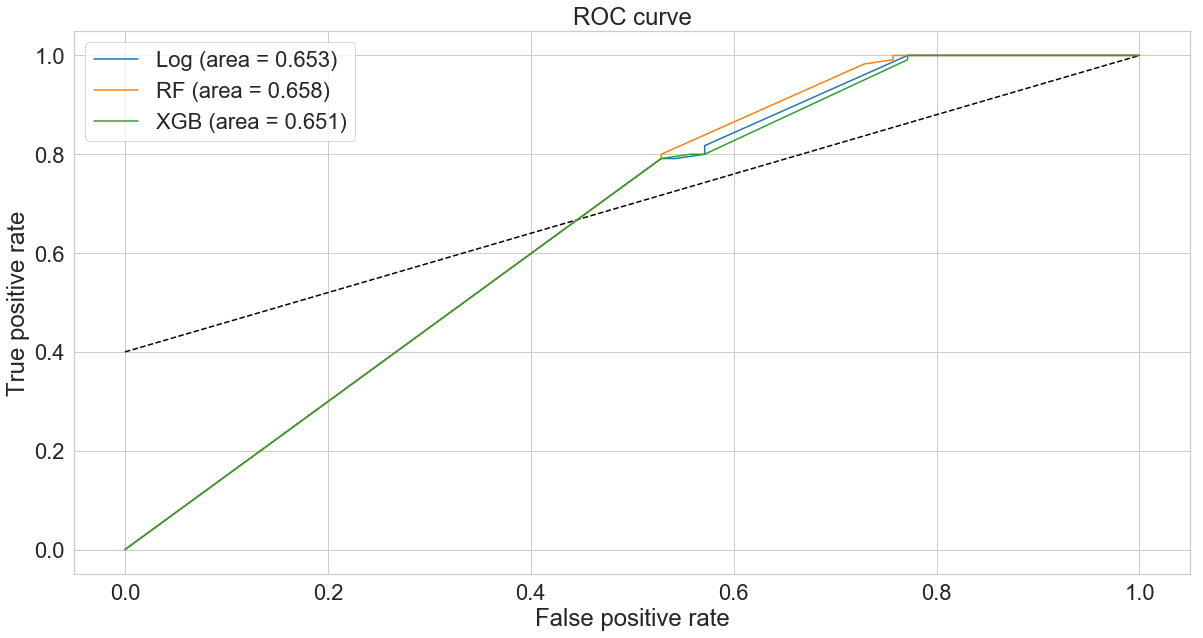

<Figure size 432x288 with 0 Axes>

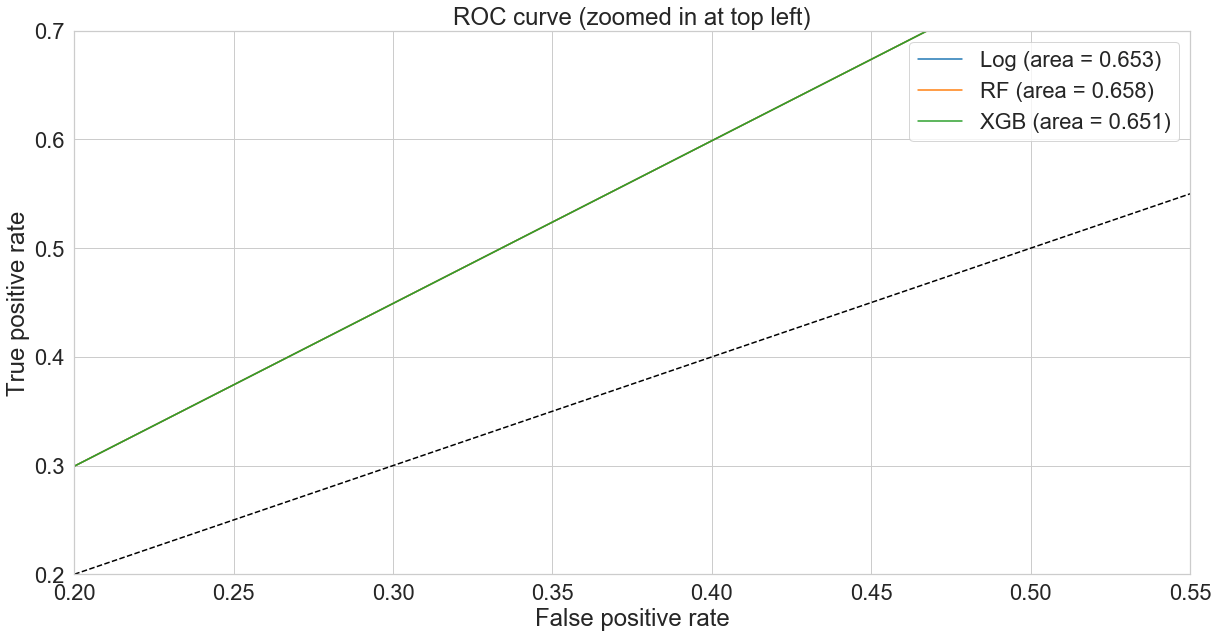

In [616]:
plt.figure(1)
plt.figure(figsize= (20, 10))
plt.plot([0, 1], [0.4, 1], 'k--')
plt.plot(fpr_log, tpr_log, label='Log (area = {:.3f})'.format(auc_log))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.plot(fpr_xgb, tpr_xgb, label='XGB (area = {:.3f})'.format(auc_xgb))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.figure(figsize= (20, 10))
plt.xlim(0.2, 0.55)
plt.ylim(0.2, 0.7)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_log, tpr_log, label='Log (area = {:.3f})'.format(auc_log))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.plot(fpr_xgb, tpr_xgb, label='XGB (area = {:.3f})'.format(auc_xgb))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [690]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

In [694]:
def show_performance_model(model, X_train, y_train, X_test, y_test):
    # check classification scores of logistic regression
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    [fpr, tpr, thr] = roc_curve(y_test, y_pred_proba)
    print('Train/Test split results:')
    print(model.__class__.__name__+" accuracy is %2.3f" % accuracy_score(y_test, y_pred))
    #print(model.__class__.__name__+" log_loss is %2.3f" % log_loss(y_test, y_pred_proba))
    print(model.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

    idx = np.min(np.where(tpr > 0.95)) # index of the first threshold for which the sensibility > 0.95

    plt.figure()
    plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
    plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
    plt.ylabel('True Positive Rate (recall)', fontsize=14)
    plt.title('Receiver operating characteristic (ROC) curve')
    plt.legend(loc="lower right")


    print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
          "and a specificity of %.3f" % (1-fpr[idx]) + 
          ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))
    return

Train/Test split results:
GaussianNB accuracy is 0.714
GaussianNB auc is 0.629
Using a threshold of 1.000 guarantees a sensitivity of 0.983 and a specificity of 0.271, i.e. a false positive rate of 72.86%.


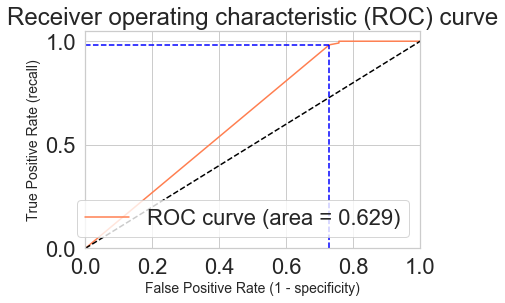

In [695]:
show_performance_model(gnb, X_train, y_train, X_test, y_test )

In [696]:
model_gnb=gnb.fit(X_train,y_train)
y_pred_gnb=model_gnb.predict(X_test)

In [698]:
from sklearn.model_selection import cross_val_score
nb_cv_score = cross_val_score(model_gnb, X, y, cv=10, scoring='roc_auc')
print("=== Mean AUC Score ===")
print("Mean AUC Score - GNb Classifier : ", nb_cv_score.mean())

=== Mean AUC Score ===
Mean AUC Score - GNb Classifier :  0.6122498106675323


Confusion Matrix :
 [[0.271429 0.728571]
 [0.017391 0.982609]]


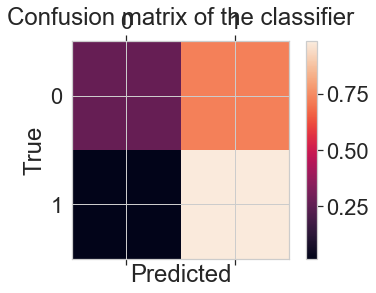

Classioficaton Report :
               precision    recall  f1-score   support

     No-Show       0.90      0.27      0.42        70
        Show       0.69      0.98      0.81       115

   micro avg       0.71      0.71      0.71       185
   macro avg       0.80      0.63      0.61       185
weighted avg       0.77      0.71      0.66       185

Precision score: 0.6890243902439024
Recall score: 0.9826086956521739
f1_score : 0.8100358422939068
fbeta_score_0.5 : 0.7328145265888456
fbeta_score_1 : 0.8100358422939068
fbeta_score_2 : 0.905448717948718
precision_recall_fscore_support : (array([0.904762, 0.689024]), array([0.271429, 0.982609]), array([0.616883, 0.732815]), array([ 70, 115], dtype=int64))
Accuracy Score: 0.7135135135135136
Loss: 0.2864864864864865


In [699]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_gnb.round())
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Confusion Matrix :\n', cm)


fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
#ax.set_xticklabels([''] + labels)
#ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, hamming_loss
target_names = ['No-Show', 'Show']
print('Classioficaton Report :\n', classification_report(y_test, y_pred_gnb.round(), target_names=target_names))

from sklearn import metrics
print('Precision score:', metrics.precision_score(y_test, y_pred_gnb.round()))
print('Recall score:', metrics.recall_score(y_test, y_pred_gnb.round()))
print('f1_score :', metrics.f1_score(y_test, y_pred_gnb.round()))  
print('fbeta_score_0.5 :', metrics.fbeta_score(y_test, y_pred_gnb.round(), beta=0.5))
print('fbeta_score_1 :', metrics.fbeta_score(y_test, y_pred_gnb.round(), beta=1)) 
print('fbeta_score_2 :', metrics.fbeta_score(y_test, y_pred_gnb.round(), beta=2)) 
print('precision_recall_fscore_support :', metrics.precision_recall_fscore_support(y_test, y_pred_gnb.round(), beta=0.5))
print('Accuracy Score:', accuracy_score(y_test,  y_pred_gnb.round(), normalize=True, sample_weight=None))
print('Loss:', hamming_loss(y_test, y_pred_gnb.round()))

In [701]:
model_gnb = rf.fit(X_train.as_matrix(), y_train.as_matrix())
model_gnb.predict_proba(X_val.as_matrix()[0].reshape(1, 6))
inp = np.array([1, 0, 1, 1, 1, 1])
model_gnb.predict_proba(inp.reshape(1, 6))

C:\Users\sumit.ghose.roy\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
C:\Users\sumit.ghose.roy\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


array([[0.351032, 0.648968]])